# 代码来源：https://blog.csdn.net/qq_42818403/article/details/122907583

In [1]:
import numpy as np
import sys
print(sys.executable)
from mpl_toolkits import mplot3d


import deepxde as dde

# 用于绘图
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

print(sys.executable)

D:\anaconda\python.exe


Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.


D:\anaconda\python.exe


In [2]:
#周期性边界条件
x_lower = -5
x_upper = 5
t_lower = 0
t_upper = np.pi/2

# 创建 2D 域（用于绘图和输入）
x = np.linspace(x_lower, x_upper, 512)
t = np.linspace(t_lower, t_upper, 402)
X, T = np.meshgrid(x, t)

# 整个域变平
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# 空间和时间域/几何（对于 deepxde 模型）
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)


In [3]:
# 损失的“物理信息”部分


def pde(x,y):
    """
    INPUTS:
        x: x[:,0] 是 x 坐标
           x[:,1] 是 t 坐标
        y: 网络输出，在这种情况下:
            y[:,0] 是 u(x,t) 实部
            y[:,1] 是 v(x,t) 虚部
    OUTPUT:
        标准形式的 pde，即必须为零的东西
    """
    
    
    u1 = y[:, 0:1]
    v1 = y[:, 1:2]
    u2 = y[:, 2:3]
    v2 = y[:, 3:4]
    

    # 在'jacobian'中，i 是输出分量，j 是输入分量
    u1_t = dde.grad.jacobian(y, x, i=0, j=1)
    v1_t = dde.grad.jacobian(y, x, i=1, j=1)
    u2_t = dde.grad.jacobian(y, x, i=2, j=1)
    v2_t = dde.grad.jacobian(y, x, i=3, j=1)

    u1_x = dde.grad.jacobian(y, x, i=0, j=0)
    v1_x = dde.grad.jacobian(y, x, i=1, j=0)
    u2_x = dde.grad.jacobian(y, x, i=2, j=0)
    v2_x = dde.grad.jacobian(y, x, i=3, j=0)

    # 在“hessian”中，i 和 j 都是输入分量。 （Hessian 原则上可以是 d^2y/dxdt、d^2y/d^2x 等）
    # 输出组件由“组件”选择
    u1_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v1_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    u2_xx = dde.grad.hessian(y, x, component=2, i=0, j=0)
    v2_xx = dde.grad.hessian(y, x, component=3, i=0, j=0)

    #f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    #f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u
    
    f_u1 = u1_t + v1_xx + 2*(v1 ** 2 + u1 ** 2 + 2*(v2 ** 2 + u2 ** 2)) * v1 - 2*v1*(v2 ** 2 - u2 ** 2) - 4*v2*u1*u2
    f_v1 = v1_t - u1_xx - 2*(v1 ** 2 + u1 ** 2 + 2*(v2 ** 2 + u2 ** 2)) * u1 - 2*u1*(v2 ** 2 - u2 ** 2) + 4*v1*v2*u2
    
    f_u2 = u2_t + v2_xx + 2*(v2 ** 2 + u2 ** 2 + 2*(v1 ** 2 + u1 ** 2)) * v2 - 2*v2*(v1 ** 2 - u1 ** 2) - 4*v1*u2*u1
    f_v2 = v2_t - u2_xx - 2*(v2 ** 2 + u2 ** 2 + 2*(v1 ** 2 + u1 ** 2)) * u2 - 2*u2*(v1 ** 2 - u1 ** 2) + 4*v2*v1*u1

    return [f_u1, f_v1,f_u2,f_v2]


In [4]:
# 边界条件和初始条件

# 周期性边界条件
bc_u1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)
bc_u2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=2
)
bc_u2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=2
)
bc_v2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=3
)
bc_v2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=3
)

# 初始条件
def init_cond_u1(x):
    "2 sech(x)"
    return 2 / np.cosh(x[:, 0:1])
def init_cond_u2(x):
    "2 tanh(x)"
    return 2* np.sinh(x[:, 0:1]) /np.cosh(x[:, 0:1])

def init_cond_v(x):
    return 0


ic_u1 = dde.IC(geomtime, init_cond_u1, lambda _, on_initial: on_initial, component=0)
ic_v1 = dde.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)
ic_u2 = dde.IC(geomtime, init_cond_u2, lambda _, on_initial: on_initial, component=2)
ic_v2 = dde.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=3)


In [5]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u1_0, bc_u1_1, bc_v1_0, bc_v1_1,bc_u2_0, bc_u2_1, bc_v2_0, bc_v2_1, ic_u1, ic_v1,ic_u2, ic_v2],
    num_domain=10000,
    num_boundary=20,
    num_initial=200,
    train_distribution="pseudo",
)

allow_unused=True
# 网络架构
net = dde.maps.FNN([2] + [200] * 4 + [4], "tanh", "Glorot normal")

model = dde.Model(data, net)


Adam 优化

In [6]:

# 强烈建议使用 GPU 加速系统.

model.compile("adam", lr=1e-3, loss="MSE")
model.train(epochs=10000, display_every=1000)


Compiling model...
Building feed-forward neural network...
'build' took 0.076164 s



C:\Users\86183\AppData\Roaming\Python\Python39\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.455635 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
0         [1.84e-02, 1.09e-03, 6.99e-03, 8.25e-03, 6.84e-03, 2.27e-04, 2.45e-01, 3.26e-05, 3.67e-01, 4.42e-04, 4.34e-02, 6.14e-05, 9.84e-01, 2.57e-02, 3.71e+00, 5.21e-03]    [1.84e-02, 1.09e-03, 6.99e-03, 8.25e-03, 6.84e-03, 2.27e-04, 2.45e-01, 3.26e-05, 3.67e-01, 4.42e-04, 4.34e-02, 6.14e-05, 9.84e-01, 2.57e-02, 3.71e+00, 5.21e-03]    []  
1000      [3.75e-02, 5.76e-02, 1.05e-01, 1.05e-01, 4.21e-05, 1.79e-04, 3.08e-04, 8.81e-04, 4.59e-02, 2.78e-04, 4.94e-03, 1.49e-04, 1.10e-01, 1.30e-03, 7.76e-01, 6.60e-04]    [3.75e-02, 5.76e-02, 1.05e-01, 1.05e-01, 4.21e-05, 1.79e-04, 

(<deepxde.model.LossHistory at 0x1e9ed97edc0>,
 <deepxde.model.TrainState at 0x1e9ed951af0>)

L-BFGS 优化

Compiling model...
'compile' took 1.873479 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
10000     [7.08e-02, 2.97e-02, 1.10e-01, 7.97e-02, 2.64e-04, 3.36e-04, 7.61e-04, 7.42e-05, 8.77e-03, 3.14e-04, 6.29e-03, 3.15e-04, 4.78e-02, 1.29e-02, 5.08e-01, 7.73e-03]    [7.08e-02, 2.97e-02, 1.10e-01, 7.97e-02, 2.64e-04, 3.36e-04, 7.61e-04, 7.42e-05, 8.77e-03, 3.14e-04, 6.29e-03, 3.15e-04, 4.78e-02, 1.29e-02, 5.08e-01, 7.73e-03]    []  
11000     [2.46e-02, 3.22e-02, 8.29e-02, 6.02e-02, 1.42e-04, 8.20e-04, 1.24e-04, 5.09e-04, 1.29e-02, 5.94e-05, 2.90e-03, 1.62e-04, 2.41e-02, 8.39e-03, 2.39e-01, 8.09e-03]                                                                        

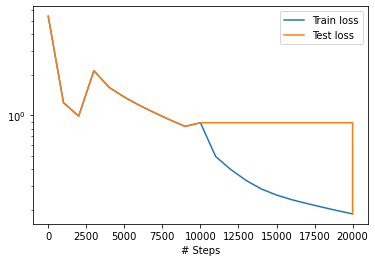

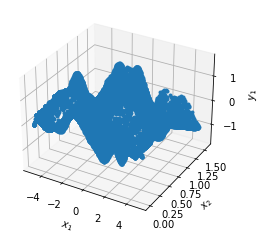

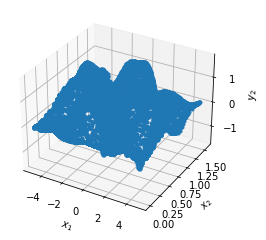

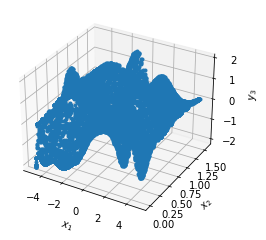

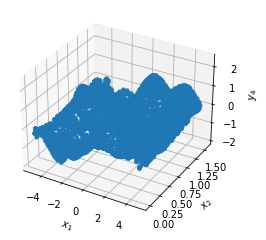

In [7]:
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=10000,
    maxfun=10000,
    maxls=50,
)
model.compile("L-BFGS")
#model.train()

losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

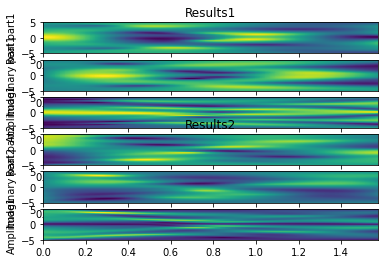

In [8]:
# 做预测
prediction = model.predict(X_star, operator=None)

u1 = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v1 = griddata(X_star, prediction[:, 1], (X, T), method="cubic")
u2 = griddata(X_star, prediction[:, 2], (X, T), method="cubic")
v2 = griddata(X_star, prediction[:, 3], (X, T), method="cubic")


h1 = np.sqrt(u1 ** 2 + v1 ** 2)
h2=np.sqrt(u2**2+v2**2)



# 绘制预测
fig, ax = plt.subplots(6)

ax[0].set_title("Results1")
ax[0].set_ylabel("Real part1")
ax[0].imshow(
    u1.T,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[t_lower, t_upper, x_lower, x_upper], #极值
    origin="lower",
    aspect="auto",
)
ax[1].set_ylabel("Imaginary part1")
ax[1].imshow(
    v1.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2].set_ylabel("Amplitude1")
ax[2].imshow(
    h1.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[3].set_title("Results2")
ax[3].set_ylabel("Real part2")
ax[3].imshow(
    u2.T,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[t_lower, t_upper, x_lower, x_upper], #极值
    origin="lower",
    aspect="auto",
)
ax[4].set_ylabel("Imaginary part2")
ax[4].imshow(
    v2.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[5].set_ylabel("Amplitude1")
ax[5].imshow(
    h2.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
plt.show()


[  3837   1525   1311 ... 612679 619137 625144]


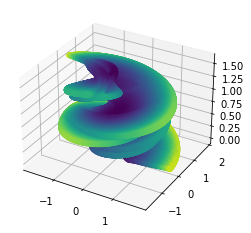

In [15]:
ax = plt.axes(projection='3d')


b=prediction[:,0]**2+prediction[:,1]**2
c=min(b)
d=b/c
d=d.astype(int)
print(d)
# Data for a three-dimensional line
ax.scatter3D(prediction[:, 0],prediction[:, 1],X_star[:,1],c=d[:])



[466904 406135 357159 ...   1250   1423   1667]
(402, 512)
(402, 512)
(205824, 2)
(205824, 4)


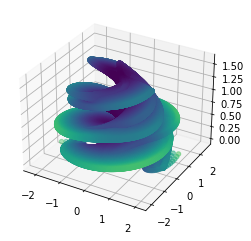

In [16]:
bx = plt.axes(projection='3d')
b=prediction[:,2]**2+prediction[:,3]**2
c=min(b)
d=b/c
d=d.astype(int)
print(d)
bx.scatter3D(prediction[:, 2],prediction[:, 3],X_star[:,1],c=d[:])

print(X.shape)
print(T.shape)
print(X_star.shape)
print(prediction.shape)